# OGGM - data pulling

## Setting up:

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
from pyproj import Transformer
import salem
from tqdm.notebook import tqdm
import logging
import matplotlib.pyplot as plt
from oggm import cfg, utils, workflow, tasks

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2025-01-14 12:52:12: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-01-14 12:52:12: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-01-14 12:52:12: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-01-14 12:52:13: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-01-14 12:52:13: oggm.cfg: Multiprocessing switched ON after user settings.
2025-01-14 12:52:13: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


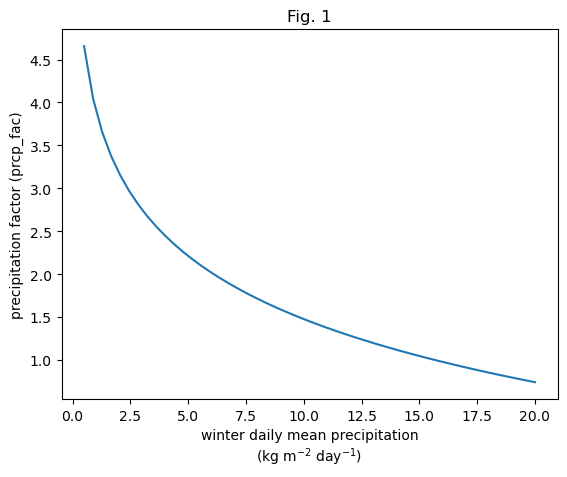

In [2]:
w_prcp_array = np.linspace(0.5, 20, 51)
# we basically do here the same as in massbalance.decide_winter_precip_factor(gdir)
a, b = cfg.PARAMS['winter_prcp_fac_ab']
r0, r1 = cfg.PARAMS['prcp_fac_min'], cfg.PARAMS['prcp_fac_max']
prcp_fac = a * np.log(w_prcp_array) + b
# don't allow extremely low/high prcp. factors!!!
prcp_fac_array = utils.clip_array(prcp_fac, r0, r1)
plt.plot(w_prcp_array, prcp_fac_array)
plt.xlabel(r'winter daily mean precipitation' +'\n'+r'(kg m$^{-2}$ day$^{-1}$)')
plt.ylabel('precipitation factor (prcp_fac)'); plt.title('Fig. 1');

# save arrays
np.save('w_prcp_array.npy', w_prcp_array)
np.save('prcp_fac_array.npy', prcp_fac_array)

## Download OGGM data:

In [3]:
# set working directory
working_dir = '../../../data/OGGM/'
cfg.PATHS['working_dir'] = working_dir

# Set RGI version and region:
rgi_region = "11"  # Central Europe
rgi_version = "6"
rgi_dir = utils.get_rgi_dir(version=rgi_version)

In [4]:
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# We use the directories with the shop data in it: "W5E5_w_data"
base_url = "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/"
gdirs = workflow.init_glacier_directories(
    rgidf,
    from_prepro_level=3,
    prepro_base_url=base_url,
    prepro_border=10,
    reset=True,
    force=True,
)

2025-01-14 12:52:14: oggm.workflow: init_glacier_directories from prepro level 3 on 3927 glaciers.
2025-01-14 12:52:15: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3927 glaciers


In [5]:
# Tested tasks
task_list = [
    tasks.gridded_attributes,
    # tasks.gridded_mb_attributes,
    # get_gridded_features,
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs, print_log=False)

2025-01-14 12:52:40: oggm.workflow: Execute entity tasks [gridded_attributes] on 3927 glaciers


## Load PMB data:

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,RGI60-11.02764
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,RGI60-11.02764
2,2006,300,adler,20051017,20061011,46.010646,7.860957,3191.502735,-2.592,annual,RGI60-11.02764


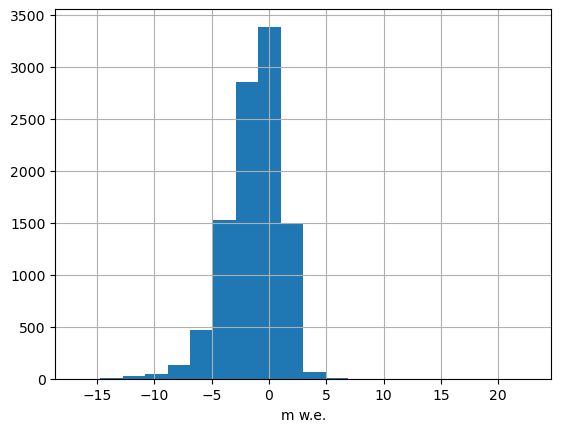

In [6]:
DF_TYPE = 'close' # 'all' or 'close' depending on whether we also want snow probes

# Load PMB data:
path_PMB_GLAMOS_csv = '../../../data/GLAMOS/point/csv/'
df_pmb = pd.read_csv(path_PMB_GLAMOS_csv + f'df_pmb_50s_clean_{DF_TYPE}.csv')
# Histogram of mass balance
df_pmb['POINT_BALANCE'].hist(bins=20)
plt.xlabel('m w.e.')
df_pmb.head(3)

In [7]:
# Get info of that sample:
i = 0
RGI = df_pmb.iloc[i].RGIId
POINT_LAT, POINT_LON = df_pmb.iloc[i].POINT_LAT, df_pmb.iloc[i].POINT_LON

# Get oggm data for that RGI ID
for gdir in gdirs:
    if gdir.rgi_id == RGI:
        break
# gdir = find_gdir(gdirs, RGI)

with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
    ds = ds.load()
ds

<xarray.Dataset>
Dimensions:                  (x: 133, y: 68)
Coordinates:
  * x                        (x) float32 -2.077e+03 -2.047e+03 ... 1.883e+03
  * y                        (y) float32 5.097e+06 5.097e+06 ... 5.095e+06
Data variables: (12/17)
    topo                     (y, x) float32 2.989e+03 2.996e+03 ... 3.613e+03
    topo_smoothed            (y, x) float32 3.007e+03 3.009e+03 ... 3.63e+03
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    glacier_ext_erosion      (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ice_divides              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    slope                    (y, x) float32 0.1747 0.1881 ... 0.3885 0.3636
    aspect                   (y, x) float32 5.814 5.666 5.472 ... 3.591 3.477
    slope_factor             (y, x) float32 2.849 2.725 2.51 ... 1.764 1.835
    dis_from_border          (y, x) float32 1.262e+03 1.253e+03 ... 834.1 852.8
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=7.87661 +k=0.9996 +x_0=0 +y_0...
    max_h_dem:      4145.0
    min_h_dem:      2858.0
    max_h_glacier:  4100.0
    min_h_glacier:  2976.0

## Merge with OGGM data:

In [8]:
# variables of interest from oggm
voi = [
    "aspect", "slope", "dis_from_border", "topo", "hugonnet_dhdt",
    "consensus_ice_thickness", "millan_ice_thickness", "millan_v", "millan_vx",
    "millan_vy"
]

# Initialise empty:
for var in voi:
    df_pmb[var] = np.nan

for i in tqdm(range(len(df_pmb)), desc='rows'):
    # Get info of that sample:
    RGI = df_pmb.iloc[i].RGIId
    POINT_LAT, POINT_LON = df_pmb.iloc[i].POINT_LAT, df_pmb.iloc[i].POINT_LON

    # Get oggm data for that RGI ID
    for gdir in gdirs:
        if gdir.rgi_id == RGI:
            break
    # gdir = find_gdir(gdirs, RGI)

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()

    # Transform stake coord to glacier system:
    transf = pyproj.Transformer.from_proj(salem.wgs84,
                                          gdir.grid.proj,
                                          always_xy=True)
    x_stake, y_stake = transf.transform(POINT_LON, POINT_LAT)  # x,y stake

    # Get glacier variables closest to these coordinates:
    stake = ds.sel(x=x_stake, y=y_stake, method="nearest")

    # Calculate min, max and median topography of glacier:
    # min_glacier = ds.where(ds.glacier_mask == 1).topo.min().values
    # max_glacier = ds.where(ds.glacier_mask == 1).topo.max().values
    # med_glacier = ds.where(ds.glacier_mask == 1).topo.median().values

    # Select variables of interest:
    stake_var = stake[voi]
    stake_var_df = stake_var.to_pandas()

    for var in stake_var_df.index:
        df_pmb.at[i, var] = stake_var_df.loc[var]

df_pmb.head()


rows:   0%|          | 0/10006 [00:00<?, ?it/s]

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,aspect,slope,dis_from_border,topo,hugonnet_dhdt,consensus_ice_thickness,millan_ice_thickness,millan_v,millan_vx,millan_vy
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,...,4.441578,0.340053,120.000000,3039.0,-1.504815,43.181839,37.110600,3.591626,3.445628,1.013618
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,...,4.772892,0.219036,30.000000,3091.0,-0.970061,41.090096,8.961324,0.975349,-0.948907,-0.058481
2,2006,300,adler,20051017,20061011,46.010646,7.860957,3191.502735,-2.592,annual,...,4.480725,0.306125,150.000000,3143.0,-1.284834,61.502941,29.594700,0.503317,-0.221818,-0.279207
3,2007,100,adler,20061011,20071009,46.010602,7.855728,3093.507997,-2.250,annual,...,4.399832,0.355558,108.166542,3026.0,-1.452664,39.826572,37.936680,3.881994,3.839135,0.575254
4,2007,200,adler,20061011,20071009,46.010169,7.858461,3124.506390,-1.836,annual,...,4.717781,0.213309,60.000000,3084.0,-1.188978,49.265205,16.608761,1.298901,-1.202490,0.491084


In [9]:
# Save to csv:
df_pmb.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_{DF_TYPE}.csv', index=False)
df_pmb.head(3)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,aspect,slope,dis_from_border,topo,hugonnet_dhdt,consensus_ice_thickness,millan_ice_thickness,millan_v,millan_vx,millan_vy
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,...,4.441578,0.340053,120.0,3039.0,-1.504815,43.181839,37.110600,3.591626,3.445628,1.013618
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,...,4.772892,0.219036,30.0,3091.0,-0.970061,41.090096,8.961324,0.975349,-0.948907,-0.058481
2,2006,300,adler,20051017,20061011,46.010646,7.860957,3191.502735,-2.592,annual,...,4.480725,0.306125,150.0,3143.0,-1.284834,61.502941,29.594700,0.503317,-0.221818,-0.279207


## Add SGI data:

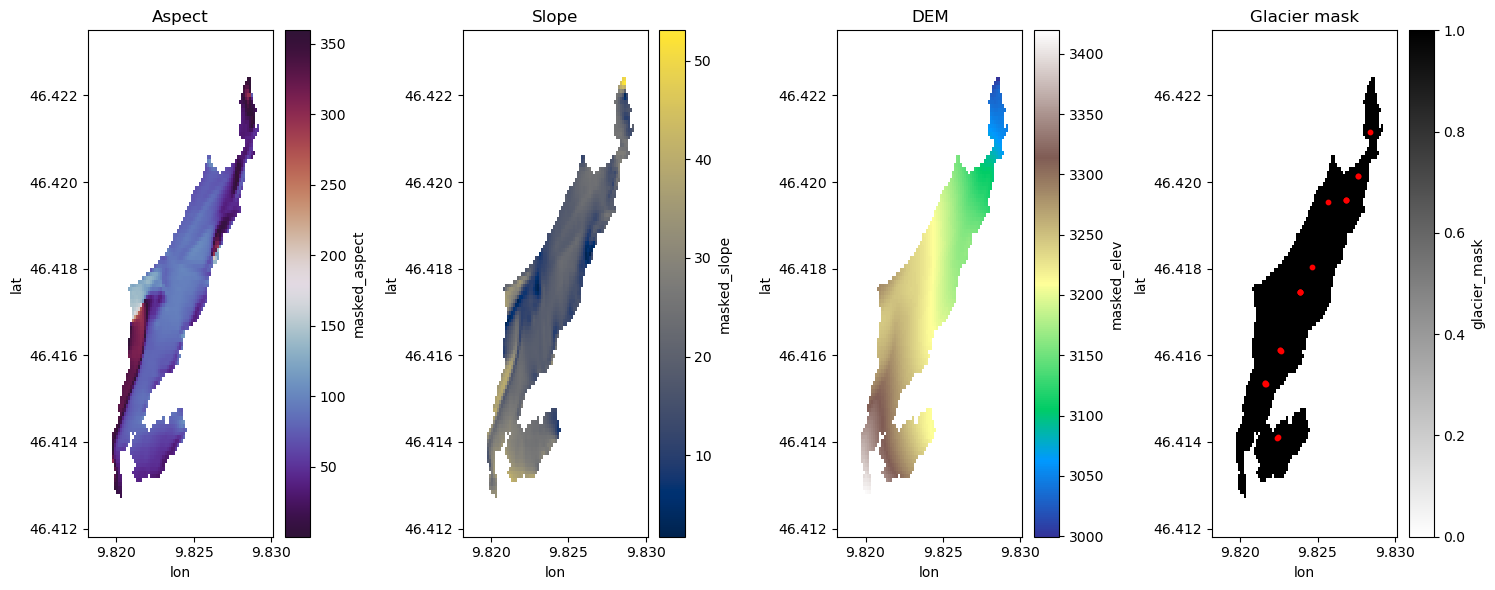

In [38]:
# Example
i = 0
# Get info of that sample:
GlacierName = 'corvatsch'
df_pmb_gl = df_pmb[df_pmb.GLACIER == GlacierName]

stake_coordinates = df_pmb_gl[['POINT_LON', 'POINT_LAT']].values
# for i in range(len(df_pmb_gl)):
RGI, YEAR, GLACIER = df_pmb_gl.iloc[i].RGIId, df_pmb_gl.iloc[i].YEAR, df_pmb_gl.iloc[i].GLACIER
POINT_LAT, POINT_LON = df_pmb_gl.iloc[i].POINT_LAT, df_pmb_gl.iloc[i].POINT_LON

# Open SGI grid:
path_SGI_topo = '../../../data/GLAMOS/topo/SGI2020/'
ds_sgi = xr.open_dataset(path_SGI_topo + 'xr_masked_grids/'+f'{GlacierName}.nc')

stake = ds_sgi.sel(lon=POINT_LON, lat=POINT_LAT, method="nearest")

# Plot the masked data
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds_sgi.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted')
ds_sgi.masked_slope.plot(ax=axs[1], cmap='cividis')
ds_sgi.masked_elev.plot(ax=axs[2], cmap='terrain')
ds_sgi.glacier_mask.plot(ax=axs[3], cmap='binary')

axs[3].scatter(stake_coordinates[:, 0], stake_coordinates[:, 1], c='r', s=10)

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

In [56]:
# variables of interest from oggm
GlacierName = 'corvatsch'
df_pmb_gl = df_pmb[df_pmb.GLACIER == GlacierName]

voi = [
    "masked_aspect", "masked_slope", "masked_elev", 
]

# Initialise empty:
for var in voi:
    df_pmb_gl[var] = np.nan

for i, row in df_pmb_gl.iterrows():
    stake_coordinates = row[['POINT_LON', 'POINT_LAT']].values
    RGI, YEAR, GLACIER = row.RGIId, row.YEAR, row.GLACIER
    POINT_LAT, POINT_LON = row.POINT_LAT, row.POINT_LON

    # Open SGI grid:
    path_SGI_topo = '../../../data/GLAMOS/topo/SGI2020/'
    ds_sgi = xr.open_dataset(path_SGI_topo + 'xr_masked_grids/'+f'{GlacierName}.nc')

    stake = ds_sgi.sel(lon=POINT_LON, lat=POINT_LAT, method="nearest")
    
    # Select variables of interest:
    stake_var = stake[voi]
    stake_var_df = stake_var.to_pandas()

    for var in stake_var_df.index:
        df_pmb_gl.loc[i, var] = stake_var_df.loc[var]
df_pmb_gl

/tmp/ipykernel_1070090/3057395380.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pmb_gl[var] = np.nan


,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,topo,hugonnet_dhdt,consensus_ice_thickness,millan_ice_thickness,millan_v,millan_vx,millan_vy,masked_aspect,masked_slope,masked_elev
2588,2013,312,corvatsch,20120828,20130831,46.416129,9.822607,3307.524247,-0.531,annual,...,3275.0,-0.627977,61.329674,29.536448,0.899568,0.830442,0.010335,80.231650,19.099451,3250.7
2589,2013,712,corvatsch,20120829,20130831,46.419595,9.826833,3199.511361,-1.359,annual,...,3168.0,0.148560,33.816040,11.691145,1.137281,-0.657608,-0.278571,52.633330,19.086286,3137.6
2590,2013,s1,corvatsch,20121001,20130419,46.416129,9.822607,3307.524247,0.876,winter,...,3275.0,-0.627977,61.329674,29.536448,0.899568,0.830442,0.010335,80.231650,19.099451,3250.7
2591,2013,s2,corvatsch,20121001,20130419,46.419595,9.826833,3199.511361,0.803,winter,...,3168.0,0.148560,33.816040,11.691145,1.137281,-0.657608,-0.278571,52.633330,19.086286,3137.6
2592,2015,412,corvatsch,20141004,20150919,46.416092,9.822645,3307.524300,-1.665,annual,...,3275.0,-0.627977,61.329674,29.536448,0.899568,0.830442,0.010335,80.063610,19.173369,3251.3
2593,2015,712,corvatsch,20141004,20150919,46.419595,9.826820,3199.511373,-2.070,annual,...,3168.0,0.148560,33.816040,11.691145,1.137281,-0.657608,-0.278571,52.633330,19.086286,3137.6
2594,2015,812,corvatsch,20141004,20150919,46.420146,9.827599,3168.509216,-1.872,annual,...,3141.0,-0.236880,31.173840,12.296777,1.954174,0.627561,-1.850666,23.540038,15.398628,3107.9
2595,2016,212,corvatsch,20150919,20160925,46.415349,9.821597,3346.527207,-0.549,annual,...,3297.0,-0.471674,37.375919,31.813320,2.079973,-1.005796,-1.820622,79.088871,22.910889,3288.1
2596,2016,412,corvatsch,20150919,20160925,46.417452,9.823888,3274.519667,-1.548,annual,...,3242.0,-0.752816,54.843731,30.403933,1.177300,-0.054753,1.176026,96.248372,19.011227,3221.2
2597,2016,812,corvatsch,20150919,20160925,46.420146,9.827599,3168.509216,-0.990,annual,...,3141.0,-0.236880,31.173840,12.296777,1.954174,0.627561,-1.850666,23.540038,15.398628,3107.9


<xarray.Dataset>
Dimensions:        ()
Coordinates:
    y              float64 ...
    x              float64 ...
    lon            float64 9.823
    lat            float64 46.42
Data variables:
    masked_aspect  float64 ...
    masked_slope   float64 ...
    masked_elev    float64 ...
    glacier_mask   int32 ...

## Add avalanche data:

In [ ]:
# set working directory
working_dir = '../../../data/OGGM/'
cfg.PATHS['working_dir'] = working_dir

# Set RGI version and region:
rgi_region = "11"  # Central Europe
rgi_version = "6"
rgi_dir = utils.get_rgi_dir(version=rgi_version)

path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# We use the directories with the shop data in it: "W5E5_w_data"
base_url = 'https://cluster.klima.uni-bremen.de/~mkneib/global_whypso/'
gdirs = workflow.init_glacier_directories(
    rgidf,
    prepro_base_url=base_url,
    from_prepro_level=3,
    prepro_border=80,
    reset=True,
    force=True,
)

In [ ]:
gdir = gdirs[0]
# Get the path to the gridded data file & open it
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
ds.snowslide_1m.where(ds.glacier_mask).plot()
plt.show()

In [ ]:
# Save to csv:
DF_TYPE = 'close' # 'all' or 'close' depending on whether we also want snow probes

# Load PMB data:
path_PMB_GLAMOS_csv = '../../../data/GLAMOS/point/csv/'

df_pmb = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_{DF_TYPE}.csv')
df_pmb.head(3)

In [ ]:
# variables of interest from oggm
voi = ["snowslide_1m"]

# Initialise empty:
for var in voi:
    df_pmb[var] = np.nan

for i in tqdm(range(len(df_pmb)), desc='rows'):
    # Get info of that sample:
    RGI = df_pmb.iloc[i].RGIId
    POINT_LAT, POINT_LON = df_pmb.iloc[i].POINT_LAT, df_pmb.iloc[i].POINT_LON

    # Get oggm data for that RGI ID
    for gdir in gdirs:
        if gdir.rgi_id == RGI:
            break
    # gdir = find_gdir(gdirs, RGI)

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()

    # Transform stake coord to glacier system:
    transf = pyproj.Transformer.from_proj(salem.wgs84,
                                          gdir.grid.proj,
                                          always_xy=True)
    x_stake, y_stake = transf.transform(POINT_LON, POINT_LAT)  # x,y stake

    # Get glacier variables closest to these coordinates:
    stake = ds.sel(x=x_stake, y=y_stake, method="nearest")

    # Select variables of interest:
    stake_var = stake[voi]
    stake_var_df = stake_var.to_pandas()

    for var in stake_var_df.index:
        df_pmb.at[i, var] = stake_var_df.loc[var]

df_pmb.head()

In [ ]:
# Save to csv:
df_pmb.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_{DF_TYPE}.csv', index=False)

In [ ]:
# Plot distribution of snowslide_1m:
df_pmb['snowslide_1m'].hist(bins=20)

In [ ]:
# Find glaciers with snowslide_1m > 1:
df_pmb[df_pmb['snowslide_1m'] > 1]

In [ ]:
df_pmb_subset = df_pmb[(df_pmb.GLACIER == 'tsanfleuron')&(df_pmb.YEAR > 2010)]
x_stakes, y_stakes, snowslide_1m_ = [], [], []
for i in tqdm(range(len((df_pmb_subset))), desc='rows'):
    # Get info of that sample:
    RGI = df_pmb_subset.iloc[i].RGIId
    POINT_LAT, POINT_LON = df_pmb_subset.iloc[i].POINT_LAT, df_pmb_subset.iloc[i].POINT_LON

    # Get oggm data for that RGI ID
    for gdir in gdirs:
        if gdir.rgi_id == RGI:
            break
    # gdir = find_gdir(gdirs, RGI)

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()

    # Transform stake coord to glacier system:
    transf = pyproj.Transformer.from_proj(salem.wgs84,
                                          gdir.grid.proj,
                                          always_xy=True)
    x_stake, y_stake = transf.transform(POINT_LON, POINT_LAT)  # x,y stake

    # Get glacier variables closest to these coordinates:
    stake = ds.sel(x=x_stake, y=y_stake, method="nearest")
    
    x_stakes.append(x_stake)
    y_stakes.append(y_stake)
    snowslide_1m_.append(stake.snowslide_1m.values)
   
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) 
ds.snowslide_1m.where(ds.glacier_mask).plot()
# plot stake
for x_stake, y_stake in zip(x_stakes, y_stakes):
    plt.scatter(x_stake, y_stake, color='r')
    
# plot distribution of snowslide_1m
plt.subplot(1, 2, 2)
plt.hist(snowslide_1m_)
plt.tight_layout()